<a href="https://colab.research.google.com/github/nelly-hateva/tardis/blob/master/notebooks/Copy_of_State_Regularized_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Prerequisities: Access data in google drive

In [2]:
from google.colab import drive

MOUNT_POINT = "/content/drive/"
DATA_DIR = MOUNT_POINT + "My Drive/Colab Notebooks/Thesis-Data"
MODELS_DIR = MOUNT_POINT + "My Drive/Colab Notebooks/Thesis-Models"
drive.mount(MOUNT_POINT)

Mounted at /content/drive/


In [ ]:
DATA_DIR = "Thesis-Data"
MODELS_DIR = "Thesis-Models"

Import libraries, set random seed and device

In [3]:
import os
import random
import string
import time
import pickle
import copy
from collections import defaultdict, Counter

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import numpy
import torch
from torch import nn, optim, utils

from sklearn.cluster import KMeans

def seed_torch(seed=666):
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  numpy.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

seed_torch()

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


State Regularized RNN

In [4]:
class SRRNN(nn.Module):

  r""" https://arxiv.org/pdf/1901.08817.pdf
       https://github.com/deepsemantic/sr-rnns
  Applies a single-layer State Regularized RNN to an input sequence.

  If :attr:`mode` is ``'rnn'``, then for each element in the input sequence computes the function

    .. math::
        h_t' = \text{tanh}(W_{ih} x_t + b_{ih} + W_{hh} h_{(t-1)} + b_{hh})

    where :math:`x_t` is the input at time `t`, :math:`h_{(t-1)}` is the hidden state
    at time `t-1` or the initial hidden state at time `0`.
    If :attr:`nonlinearity` is ``'relu'``, then `ReLU` is used instead of `tanh`.

  If :attr:`mode` is ``'gru'``, then for each element in the input sequence computes the function

    .. math::
      \begin{array}{ll} \\
        r_t = \sigma(W_{ir} x_t + b_{ir} + W_{hr} h_{(t-1)} + b_{hr}) \\
        z_t = \sigma(W_{iz} x_t + b_{iz} + W_{hz} h_{(t-1)} + b_{hz}) \\
        n_t = \tanh(W_{in} x_t + b_{in} + r_t * (W_{hn} h_{(t-1)}+ b_{hn})) \\
        h_t' = (1 - z_t) * n_t + z_t * h_{(t-1)}
      \end{array}

    where :math:`x_t` is the input at time `t`, :math:`h_{(t-1)}` is the hidden state
    at time `t-1` or the initial hidden state at time `0`.
    :math:`r_t`, :math:`z_t`, :math:`n_t` are the reset, update, and new gates, respectively.
    :math:`\sigma` is the sigmoid function, and :math:`*` is the Hadamard product.

  In both modes, if :attr:`number_of_states` is ``None``, then the hidden state
  at time `t` :math:`h_t` equals :math:`h_t'`. 

  Otherwise,

    .. math::
      \begin{array}{ll} \\
        \alpha_{i} = \frac{\exp(- \Vert{h_t' - s_i}\Vert / \tau)}{\sum_{i=1}^{k} \exp(- \Vert{h_t' - s_i}\Vert / \tau)}
        h_t = {\sum_{i=1}^{k} \alpha_{i} s_i}
      \end{array}

    where :math:`\{s_1, s_2, ..., s_k\}` are the k learnable states. 
    :math:`\alpha_{i}` is the probability of the RNN to transition to state i
    given the vector :math:`h_t'` for which we write :math:`p_{h_t'}(i) = \alpha_{i}`
    :math:`\tau` is a temperature parameter that can be used to anneal
    the probabilistic state transition behavior. The lower :math:`\tau` the
    more :math:`\alpha` resembles the one-hot encoding of a centroid. The
    higher :math:`\tau` the more uniform is :math:`\alpha`

    Args:
        input_size: The number of expected features in the input `x`
        hidden_size: The number of features in the hidden state `h`
        mode: The RNN mode to use.
          Can be either ``'rnn'`` or ``'gru'``. Default: ``'rnn'``
        nonlinearity: The non-linearity to use if :attr:`mode` is ``'rnn'``.
          Can be either ``'tanh'`` or ``'relu'``. Default: ``'tanh'``
        bias: If ``False``, then the layer does not use bias weights `b_ih` and `b_hh`.
            Default: ``True``
        number_of_states: The number of learnable finite states.
          If ``None`` then the stohastic component is not used. Default: ``None``
        temperature: The temperature parameter

    Inputs: input, h_0
        - **input** of shape `(batch, seq_len, input_size)`:
          tensor containing the features of the input sequence.
          The input can also be a packed variable length sequence.
          See :func:`torch.nn.utils.rnn.pack_padded_sequence` or
          :func:`torch.nn.utils.rnn.pack_sequence` for details.
        - **h_0** of shape `(batch, hidden_size)`: tensor
          containing the initial hidden state for each element in the batch.

          If `h_0` is not provided, it defaults to zero.

    Outputs: output, h_n
        - **output** of shape `(batch, seq_len, hidden_size)`: tensor
          containing the output features `(h_t)` from the RNN for each `t`.
          If a :class:`torch.nn.utils.rnn.PackedSequence` has been
          given as the input, the output will also be a packed sequence.
        - **h_n** of shape `(batch, hidden_size)`: tensor
          containing the hidden state for `t = seq_len`.

    Attributes:
        If :attr:`mode` is ``'rnn'``
          weight_ih: the learnable input-hidden weights,
              of shape `(hidden_size, input_size)`
          weight_hh: the learnable hidden-hidden weights,
              of shape `(hidden_size, hidden_size)`
          bias_ih: the learnable input-hidden bias,
              of shape `(hidden_size)`
          bias_hh: the learnable hidden-hidden bias,
              of shape `(hidden_size)`
        If :attr:`mode` is ``'gru'``
          weight_ih : the learnable input-hidden weights
              (W_ir|W_iz|W_in), of shape `(3*hidden_size, input_size)`
          weight_hh : the learnable hidden-hidden weights
              (W_hr|W_hz|W_hn), of shape `(3*hidden_size, hidden_size)`
          bias_ih : the learnable input-hidden bias
              (b_ir|b_iz|b_in), of shape `(3*hidden_size)`
          bias_hh : the learnable hidden-hidden bias
              (b_hr|b_hz|b_hn), of shape `(3*hidden_size)`
        states: the learnable finite number of states, of shape
            `(number_of_states, hidden_size)

    .. note::
        All the weights and biases are initialized from :math:`\mathcal{U}(-\sqrt{k}, \sqrt{k})`
        where :math:`k = \frac{1}{\text{hidden\_size}}`

    Examples::
        >>> rnn = SRRNN(10, 20)
        >>> input = torch.randn(6, 3, 10)
        >>> h_0 = torch.randn(6, 20)
        >>> output, h_n = rnn(input, h_0)
    """

  def __init__(
    self, input_size, hidden_size, bias=True, mode='rnn', nonlinearity='tanh',
    number_of_states=None, temperature=1.00
  ):
    super(SRRNN, self).__init__()

    self.input_size = input_size
    self.hidden_size = hidden_size
    self.bias = bias

    if mode == 'rnn':
      self.rnn_cell = nn.RNNCell(
        input_size, hidden_size, bias=bias, nonlinearity=nonlinearity
      )
    elif mode == 'gru':
      self.rnn_cell = nn.GRUCell(
        input_size, hidden_size, bias=bias
      )
    else:
      raise ValueError("Unknown mode '{}'".format(mode))

    self.stohastic_component = False

    if number_of_states:
      self.stohastic_component = True
      self.number_of_states = number_of_states

      self.softmax = nn.Softmax(dim=1)
      self.states = nn.Parameter(
        torch.Tensor(
            self.number_of_states, hidden_size
        )
      )
      torch.nn.init.uniform_(self.states, a=-0.5, b=0.5)
      self.temperature = temperature

  def extra_repr(self):
    s = ''
    if 'number_of_states' in self.__dict__:
      s = 'number_of_states={number_of_states}'
      if 'temperature' in self.__dict__ and self.temperature != 1.00:
        s += ', temperature={temperature}'

    return s.format(**self.__dict__)

  def permute_hidden(self, hidden, permutation, dim=0):
    if permutation is None:
      return hidden
    return hidden.index_select(dim, permutation)

  def forward(self, input, h_0=None):
    orig_input = input

    if isinstance(orig_input, nn.utils.rnn.PackedSequence):
      input, batch_sizes, sorted_indices, unsorted_indices = input
      max_batch_size = int(batch_sizes[0])
    else:
      max_batch_size, sorted_indices = input.size(0), None

    if h_0 is None:
      h_0 = torch.zeros(
        max_batch_size, self.hidden_size, dtype=input.dtype, device=input.device
      )
      #  h_0 = self.states[0].expand(max_batch_size, -1)
    else:
      # Each batch of the hidden state should match the input sequence that
      # the user believes he/she is passing in.
      h_0 = self.permute_hidden(h_0, sorted_indices)

    if isinstance(orig_input, nn.utils.rnn.PackedSequence):
      output, hidden, transition_probabilities = self.forward_packed(input, batch_sizes, h_0)

      if self.stohastic_component:
        transition_probabilities = nn.utils.rnn.PackedSequence(
          transition_probabilities, batch_sizes, sorted_indices, unsorted_indices
        )

      hidden = self.permute_hidden(hidden, unsorted_indices)
      output = nn.utils.rnn.PackedSequence(
        output, batch_sizes, sorted_indices, unsorted_indices
      )

      return output, hidden, transition_probabilities

    return self.forward_tensor(input, h_0)

  def forward_tensor(self, input, h_0):
    output, h_t = [], h_0

    if self.stohastic_component:
      transition_probabilities = []

    for t in range(input.size(1)):
      result = self.forward_impl(input[:,t,:], h_t)
      if self.stohastic_component:
        transition_probs, h_t = result
        transition_probabilities.append(transition_probs)
      else:
        h_t = result
      output.append(h_t)

    output = torch.stack(output).permute(1, 0, 2)

    if self.stohastic_component:
      return output, h_t, torch.stack(transition_probabilities).permute(1, 0, 2)
    return output, h_t, None

  def forward_packed(self, input, batch_sizes, h_0):
    output, h_n, t, h_t = [], [], 0, h_0

    if self.stohastic_component:
      transition_probabilities = []

    for batch_size in batch_sizes:
      batch_size = int(batch_size)

      h_t, h_n_ = h_t[:batch_size], h_t[batch_size:]
      h_n.append(h_n_)
      result = self.forward_impl(input[t : t + batch_size], h_t)

      if self.stohastic_component:
        transition_probs, h_t = result
        transition_probabilities.append(transition_probs)
      else:
        h_t = result

      output.append(h_t)
      t += batch_size

    h_n.append(h_t)
    h_n.reverse()

    output, h_n = torch.cat(output), torch.cat(h_n)

    if self.stohastic_component:
      return output, h_n, torch.cat(transition_probabilities)
    return output, h_n, None

  def forward_impl(self, input, h_t):
    h_t_ = self.rnn_cell(input, h_t)
    if self.stohastic_component:
      # print("self.states ", self.states.size(), self.states)
      # print("h_t_ ", h_t_.size(), h_t_)
      # print("h_t_.unsqueeze(1) ", h_t_.unsqueeze(1).size(), h_t_.unsqueeze(1))
      # print("self.states - h_t_.unsqueeze(1) ", (self.states - h_t_.unsqueeze(1)).size(), self.states - h_t_.unsqueeze(1))
      # print("torch.pow(self.states - h_t_.unsqueeze(1), 2) ", torch.pow(self.states - h_t_.unsqueeze(1), 2).size(), torch.pow(self.states - h_t_.unsqueeze(1), 2))
      # print("- torch.pow(self.states - h_t_.unsqueeze(1), 2).sum(2) ", - torch.pow(self.states - h_t_.unsqueeze(1), 2).sum(2))
      # print("(- torch.pow(self.states - h_t_.unsqueeze(1), 2).sum(2)) / self.temperature",(- torch.pow(self.states - h_t_.unsqueeze(1), 2).sum(2)) / self.temperature)
      transition_probs = self.softmax(
        (- torch.pow(self.states - h_t_.unsqueeze(1), 2).sum(2)) / self.temperature
      )
      return transition_probs, torch.matmul(transition_probs, self.states)
    return h_t_

Test for pack padded sequences

In [ ]:
with torch.no_grad():
  for _ in range(1024):

    batch_size = random.randint(1, 15)
    seq_length = random.randint(1, 15)
    input_size = random.randint(1, 5)
    hidden_size = random.randint(1, 5)
    bias = bool(random.getrandbits(1))
    nonlinearity = random.choice(['tanh', 'relu'])
    mode = random.choice(['rnn', 'gru'])
    number_of_states = random.randint(1, 15)
    temperature = random.choice([1.00, 0.5, 0.1])

    input = torch.rand(batch_size, seq_length, input_size).to(device)
    h_0 = torch.rand(batch_size, hidden_size).to(device)

    lengths = torch.randint(1, seq_length + 1, (batch_size,)).to(device)
    packed_sequence = torch.nn.utils.rnn.pack_padded_sequence(
      input, lengths, batch_first=True, enforce_sorted=False
    )

    # without stohastic component
    model = SRRNN(
      input_size, hidden_size, bias=bias, mode=mode, nonlinearity=nonlinearity
    )
    model.to(device)

    output, h_n, _ = model(input, h_0)

    assert h_n.size() == (batch_size, hidden_size)
    assert output.size() == (batch_size, seq_length, hidden_size)

    output_packed, h_n_packed, _ = model(packed_sequence, h_0)

    assert h_n_packed.size() == (batch_size, hidden_size)
    assert output_packed.data.size() == (lengths.sum().item(), hidden_size)

    for i in range(batch_size):
      assert torch.allclose(h_n_packed[i,:], output[i, lengths[i].item() - 1, :], atol=1e-07)

    # with stohastic component
    model = SRRNN(
      input_size, hidden_size, bias=bias, mode=mode, nonlinearity=nonlinearity,
      number_of_states=number_of_states, temperature=temperature
    )
    model.to(device)

    output, h_n, transition_probabilities = model(input, h_0)

    assert h_n.size() == (batch_size, hidden_size)
    assert output.size() == (batch_size, seq_length, hidden_size)
    assert transition_probabilities.size() == (batch_size, seq_length, number_of_states)

    output_packed, h_n_packed, transition_probabilities_packed = model(packed_sequence, h_0)

    assert h_n_packed.size() == (batch_size, hidden_size)
    assert output_packed.data.size() == (lengths.sum().item(), hidden_size)
    assert transition_probabilities_packed.data.size() == (lengths.sum().item(), number_of_states)

    for i in range(batch_size):
      assert torch.allclose(h_n_packed[i,:], output[i, lengths[i].item() - 1, :], atol=1e-07)

In [ ]:
class NLNN(nn.Module):

  def __init__(self, params):
    super(NLNN, self).__init__()

    # + 1 because of the padding with 0s
    num_embeddings = params['num_embeddings'] + 1

    if 'embedding_dim' in params:
      embedding_dim = params['embedding_dim']
      self.embeddings = nn.Embedding(
        num_embeddings,
        embedding_dim,
        padding_idx = 0
      )
      input_size = embedding_dim
    else:
      # one hot encoding
      self.embeddings = nn.Embedding(
          num_embeddings,
          num_embeddings,
          padding_idx = 0
      )
      nn.init.eye_(self.embeddings.weight.data)
      self.embeddings.weight.requires_grad = False
      input_size = num_embeddings

    if 'number_of_states' in params:
      self.rnn = SRRNN(
        input_size, params['hidden_size'], bias=params['bias'],
        mode=params['mode'], nonlinearity=params['nonlinearity'],
        number_of_states=params['number_of_states'],
        temperature=params['temperature']
      )
    else:
      self.rnn = SRRNN(
        input_size, params['hidden_size'], bias=params['bias'],
        mode=params['mode'], nonlinearity=params['nonlinearity']
      )

    self.linear = nn.Linear(
      in_features=params['hidden_size'], out_features=2, bias=True
    )

    self.softmax = nn.Softmax(dim=1)

  def forward(
    self, x, length,
    h_0=None, return_rnn_output=False, return_probabilities=False
  ):
    embedding_output = self.embeddings(x)
    packed_sequence = nn.utils.rnn.pack_padded_sequence(
      embedding_output, length, batch_first=True, enforce_sorted=False
    )

    if h_0 is not None:
      rnn_output, h_n, transition_probabilities = self.rnn(packed_sequence, h_0=h_0)
    else:
      rnn_output, h_n, transition_probabilities = self.rnn(packed_sequence)

    linear_output = self.linear(h_n)
    softmax_output = self.softmax(linear_output)

    if return_rnn_output and return_probabilities:
      return softmax_output, rnn_output, transition_probabilities
    elif return_rnn_output:
      return softmax_output, rnn_output
    elif return_probabilities:
      return softmax_output, transition_probabilities
    else:
      return softmax_output

In [ ]:
class NLDataset(utils.data.Dataset):

  def __init__(self, dataset):
    data, length, labels = dataset
    self.data = torch.tensor(data).long().to(device)
    self.length = torch.tensor(length).long().to(device)
    self.labels = torch.tensor(labels).long().to(device)

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    return {
      'x': self.data[idx],
      'length': self.length[idx],
      'y': self.labels[idx]
    }

def load_data(filename_data, filename_length, filename_labels):
  return numpy.load(filename_data, allow_pickle=True), \
    numpy.load(filename_length, allow_pickle=True), \
    numpy.load(filename_labels, allow_pickle=True)

In [ ]:
def __evaluate(predictions, labels):
  assert(len(predictions) == len(labels))

  tp, tn, fp, fn = 0, 0, 0, 0
  for prediction, label in zip(predictions, labels):
    if label == 1:
      if prediction == 1:
        tp += 1
      else:
        fn += 1
    else:
      if prediction == 1:
        fp += 1
      else:
        tn += 1

  if tp == 0:
    if fn == 0 and fp == 0:
      pr, r, f1 = 1, 1, 1
    else:
      pr, r, f1 = 0, 0, 0
  else:
    pr = tp / (tp + fp)
    r = tp / (tp + fn)
    f1 = 2 * ((pr * r) / (pr + r))

  accuracy = (tp + tn) / (tp + tn + fp + fn)

  return tp, tn, fp, fn, pr, r, f1, accuracy

def _evaluate(data_loader, model):
  model.eval()

  predictions, labels = [], []

  for data in data_loader:
    t0 = time.time()
    result = model(data['x'], data['length'])
    argmax = result.argmax(dim=1).detach().cpu().numpy()
    predictions.extend(list(argmax))
    labels.extend(list(data['y'].detach().cpu().numpy()))

  return __evaluate(predictions, labels)

def evaluate_model(data_loader, model, set_name):
  tp, tn, fp, fn, pr, r, f1, acc = _evaluate(data_loader, model)
  print("{} : TP : {} TN : {} FP : {} FN : {} Pr : {} R : {} F1: {} ACC : {} ".format(
    set_name, tp, tn, fp, fn, pr, r, f1, acc
  ))

def model_summary(model):
  print (model)
  print()

  print("Trainable parameters:")
  for name, param in model.named_parameters():
    if param.requires_grad:
      print (" ", name)
  print()

  number_of_trainable_parameters = sum(
    p.numel() for p in model.parameters() if p.requires_grad
  )
  print("Number of trainable parameters {0:,}".format(
    number_of_trainable_parameters
  ))
  print()

def train_model(
    model, params=None, params_path=None, model_path=None,
    train_loader=None, dev_loader=None
):
  model.to(device)
  model_summary(model)

  loss_function = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])

  best_accuracy, best_state_dict, best_epoch = 0, dict(), -1

  # first_batch = next(iter(train_loader))
  # print (first_batch)

  for epoch in range(params['num_epochs']):
    print('Epoch {}/{} : '.format(epoch, params['num_epochs']))
    t0 = time.time()

    model.train() # set the model to training mode
    #for data in [first_batch] * 1:
    for data in train_loader:
      model.zero_grad()
      predictions = model(data['x'], data['length'])
      batch_loss = loss_function(predictions, data['y'])
      batch_loss.backward()
      optimizer.step()

    _, _, _, _, _, _, _, dev_accuracy = _evaluate(dev_loader, model)

    if dev_accuracy > best_accuracy:
      best_accuracy = dev_accuracy
      best_state_dict = copy.deepcopy(model.state_dict())
      best_epoch = epoch

    print(
      "dev accuracy:{}\ttime:{:.2f}s"
      .format(dev_accuracy, time.time() - t0)
    )

    # _, _, _, _, _, _, _, train_accuracy = _evaluate(train_loader, model)

    # if train_accuracy > best_accuracy:
    #   best_accuracy = train_accuracy
    #   best_state_dict = copy.deepcopy(model.state_dict())
    #   best_epoch = epoch

    # print(
    #   "train accuracy:{}\ttime:{:.2f}s"
    #   .format(train_accuracy, time.time() - t0)
    # )

  model.load_state_dict(best_state_dict)
  print("Best epoch {} and accuracy {}".format(best_epoch, best_accuracy))

  if model_path:
    torch.save(model.state_dict(), MODELS_DIR + model_path)
    if params_path:
      with open(MODELS_DIR + params_path, 'wb') as f:
        pickle.dump(params, f)

  #evaluate_model([first_batch] * 1, model, "train")
  evaluate_model(train_loader, model, "train")
  evaluate_model(dev_loader, model, "dev")

  return model

In [ ]:
train_data = load_data(
  DATA_DIR + "/words/train.data.npy",
  DATA_DIR + "/words/train.length.npy",
  DATA_DIR + "/words/train.labels.npy"
)
dev_data = load_data(
  DATA_DIR + "/words/dev.data.npy",
  DATA_DIR + "/words/dev.length.npy",
  DATA_DIR + "/words/dev.labels.npy"
)
test_data = load_data(
  DATA_DIR + "/words/test.data.npy",
  DATA_DIR + "/words/test.length.npy",
  DATA_DIR + "/words/test.labels.npy"
)

alphabet = {}
with open(DATA_DIR + "/words/alphabet.dict", "rb") as f:
  alphabet = pickle.load(f)

params = {
  'batch_size': 2,
  'num_epochs': 500,
  'num_embeddings': len(alphabet),
  #'embedding_dim': 10,
  'mode': 'rnn',
  'nonlinearity': 'relu',
  'hidden_size': 8,
  'bias': False
}

train_loader = utils.data.DataLoader(
  NLDataset(train_data), batch_size=params["batch_size"], shuffle = True
)
dev_loader = utils.data.DataLoader(
  NLDataset(dev_data), batch_size=params["batch_size"]
)
test_loader = utils.data.DataLoader(
  NLDataset(test_data), batch_size=params["batch_size"]
)

model = NLNN(params)
train_model(
  model,
  params=params,
  params_path="/words/rnn3.model.params",
  model_path="/words/rnn3.model.pt",
  train_loader=train_loader, dev_loader=dev_loader
)
#evaluate_model(dev_loader, model, "dev")
evaluate_model(test_loader, model, "test")

NLNN(
  (embeddings): Embedding(24, 24, padding_idx=0)
  (rnn): SRRNN(
    (rnn_cell): RNNCell(24, 8, bias=False, nonlinearity=relu)
  )
  (linear): Linear(in_features=8, out_features=2, bias=True)
  (softmax): Softmax(dim=1)
)

Trainable parameters:
  rnn.rnn_cell.weight_ih
  rnn.rnn_cell.weight_hh
  linear.weight
  linear.bias

Number of trainable parameters 274

Best epoch 485 and accuracy 0.9568421052631579
train : TP : 461 TN : 448 FP : 23 FN : 18 Pr : 0.9524793388429752 R : 0.9624217118997912 F1: 0.9574247144340602 ACC : 0.9568421052631579 
dev : TP : 52 TN : 52 FP : 13 FN : 2 Pr : 0.8 R : 0.9629629629629629 F1: 0.8739495798319328 ACC : 0.8739495798319328 
test : TP : 57 TN : 47 FP : 11 FN : 4 Pr : 0.8382352941176471 R : 0.9344262295081968 F1: 0.8837209302325582 ACC : 0.8739495798319328 


In [ ]:
def load_model(params_path=None, model_path=None):
  with open(MODELS_DIR + params_path, 'rb') as f:
    params = pickle.load(f)
  model = NLNN(params)
  checkpoint = torch.load(MODELS_DIR + model_path, map_location=device)
  if 'model_state_dict' in checkpoint:
    model.load_state_dict(checkpoint['model_state_dict'])
  else:
    model.load_state_dict(checkpoint)
  model.to(device)
  return model, params

Get vectors from pre-trained model

In [ ]:
def get_model_vectors(model, params, dataset_loader):

  with torch.no_grad():
    vectors, dataset_size = [], 0

    for data in train_loader:
      x, length = data['x'], data['length']
      dataset_size += x.size(0)
      _, rnn_output = model(x, length, return_rnn_output=True)
      softmax_output =  model.softmax(model.linear(rnn_output.data))
      vectors.extend(
        torch.cat((rnn_output.data, softmax_output), dim=1).cpu().detach().numpy()
      )

    h_0 = torch.zeros((1, params['hidden_size']), device=device)
    h_0 = torch.cat((h_0, model.softmax(model.linear(h_0))), dim=1)
    vectors.extend(
      h_0.expand(dataset_size, params['hidden_size'] + 2).cpu().detach().numpy()
    )

    vectors, counts = numpy.unique(numpy.array(vectors), axis=0, return_counts=True)

    print("Number of unique vectors {0:,}".format(vectors.shape[0]))
    print("Number of total vectors {0:,}".format(numpy.sum(counts)))

  return vectors, counts


In [ ]:
model, params = load_model(
    params_path="/numeral-50/rnn.model.params",
    model_path="/numeral-50/rnn.model.pt"
)
train_data = load_data(
  DATA_DIR + "/numeral-50/train.data.npy",
  DATA_DIR + "/numeral-50/train.length.npy",
  DATA_DIR + "/numeral-50/train.labels.npy"
)
train_loader = utils.data.DataLoader(
  NLDataset(train_data), batch_size=500, shuffle = False
)

vectors, counts = get_model_vectors(model, params, train_loader)

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

fig = plt.figure(figsize=(50, 50))
pca = PCA(n_components=2)
reduced = pca.fit_transform(vectors)

t = reduced.transpose()

plt.scatter(t[0], t[1])
plt.show()

# numpy.savetxt(MODELS_DIR + "/words/rnn.model.vectors.npy.gz", vectors)
# numpy.savetxt(MODELS_DIR + "/words/rnn.model.vectors.counts.npy.gz", counts, fmt='%d')
# numpy.save(MODELS_DIR + "/words/rnn.model.vectors.npy", vectors)
# numpy.save(MODELS_DIR + "/words/rnn.model.vectors.weights.npy", counts)


In [ ]:
def read_centroids(file):
  centroids = []
  with open(file, "r") as f:
    lines = f.readlines()
    for line in lines:
      line = line.strip()
      if line:
        centroids.append([float(p) for p in line.split()])

  print("Number of centroids: {0:,}".format(len(centroids)))

  return torch.tensor(centroids).cuda()

centroids = read_centroids(MODELS_DIR + "/numeral-50/rnn.model.vectors.txt.centroids.txt")
print (centroids)

FileNotFoundError: ignored

In [ ]:
train_data = load_data(
  DATA_DIR + "/numeral/train.data.npy",
  DATA_DIR + "/numeral/train.length.npy",
  DATA_DIR + "/numeral/train.labels.npy"
)
dev_data = load_data(
  DATA_DIR + "/numeral/dev.data.npy",
  DATA_DIR + "/numeral/dev.length.npy",
  DATA_DIR + "/numeral/dev.labels.npy"
)
test_data = load_data(
  DATA_DIR + "/numeral/test.data.npy",
  DATA_DIR + "/numeral/test.length.npy",
  DATA_DIR + "/numeral/test.labels.npy"
)

model, params = load_model(
    params_path="/numeral/rnn2.model.params",
    model_path="/numeral/rnn2.model.pt"
)

params['batch_size'] = 10
params['lr'] = 0.0001
params['weight_decay'] = 0.005
train_loader = utils.data.DataLoader(
  NLDataset(train_data), batch_size=params['batch_size'], shuffle = True
)
dev_loader = utils.data.DataLoader(
  NLDataset(dev_data), batch_size=params['batch_size'], shuffle = False
)
test_loader = utils.data.DataLoader(
  NLDataset(test_data), batch_size=params['batch_size'], shuffle = False
)

vectors, counts = get_model_vectors(model, params, train_loader)

clusters = KMeans(
    n_clusters=500,
    init="k-means++",
    random_state=0
).fit(vectors, None, counts).cluster_centers_
numpy.save(MODELS_DIR + "/numeral/st-debug-rnn2.model.centers.npy", clusters)

params['num_epochs'] = 100
params['number_of_states'] = 500
params['temperature'] = 0.1


stohastic_model = NLNN(params)
stohastic_model.load_state_dict(model.state_dict(), strict=False)
stohastic_model.embeddings.weight.requires_grad=False
stohastic_model.rnn.rnn_cell.weight_ih.requires_grad=False
stohastic_model.rnn.rnn_cell.weight_hh.requires_grad=False

stohastic_model.rnn.states.data = torch.from_numpy(clusters[:,:-2]).float().to(device)
stohastic_model.to(device)

# alphabet = {}
# with open(DATA_DIR + "/numeral-50/alphabet.dict", "rb") as f:
#   alphabet = pickle.load(f)

# inv_alphabet = { v : k for k, v in alphabet.items() }
# torch.set_printoptions(precision=4)
# torch.set_printoptions(threshold=5000)
# torch.set_printoptions(sci_mode=False)
# x = torch.tensor(list(inv_alphabet.keys()), device=device).unsqueeze(1)
# length = torch.ones(len(inv_alphabet), device=device)

# h_0 = torch.zeros((len(inv_alphabet), params['hidden_size']), device=device)

# softmax_output, rnn_output, transition_probabilities = stohastic_model(x, length, h_0=h_0, return_probabilities=True, return_rnn_output=True)
# transition_probabilities, _ = nn.utils.rnn.pad_packed_sequence(transition_probabilities, batch_first=True)
# next_states = torch.argmax(transition_probabilities[:, 0, ], dim=1)

# print(torch.max(transition_probabilities[:, 0, ], dim=1))
# print(inv_alphabet)
# softmax_output, rnn_output = model(x, length, h_0=h_0 , return_rnn_output=True)
# print(rnn_output)

# model_summary(stohastic_model)
stohastic_model = train_model(
  stohastic_model,
  params=params,
  train_loader=train_loader, dev_loader=dev_loader,
  params_path="/numeral/st-debug-rnn2.model.params",
  model_path="/numeral/st-debug-rnn2.model.pt",
)


Number of unique vectors 3,569
Number of total vectors 10,944
NLNN(
  (embeddings): Embedding(24, 24, padding_idx=0)
  (rnn): SRRNN(
    number_of_states=500, temperature=0.1
    (rnn_cell): RNNCell(24, 8, bias=False, nonlinearity=relu)
    (softmax): Softmax(dim=1)
  )
  (linear): Linear(in_features=8, out_features=2, bias=True)
  (softmax): Softmax(dim=1)
)

Trainable parameters:
  rnn.states
  linear.weight
  linear.bias

Number of trainable parameters 4,018

Epoch 0/100 : 
dev accuracy:0.773109243697479	time:1.05s
Epoch 1/100 : 
dev accuracy:0.773109243697479	time:1.03s
Epoch 2/100 : 
dev accuracy:0.773109243697479	time:1.03s
Epoch 3/100 : 
dev accuracy:0.773109243697479	time:1.03s
Epoch 4/100 : 
dev accuracy:0.773109243697479	time:1.07s
Epoch 5/100 : 
dev accuracy:0.8151260504201681	time:1.04s
Epoch 6/100 : 
dev accuracy:0.8067226890756303	time:1.09s
Epoch 7/100 : 
dev accuracy:0.8067226890756303	time:0.98s
Epoch 8/100 : 
dev accuracy:0.8067226890756303	time:1.01s
Epoch 9/100 : 
d

Train stohastic model

In [ ]:
train_data = load_data(
  DATA_DIR + "/numeral/train.data.npy",
  DATA_DIR + "/numeral/train.length.npy",
  DATA_DIR + "/numeral/train.labels.npy"
)
dev_data = load_data(
  DATA_DIR + "/numeral/dev.data.npy",
  DATA_DIR + "/numeral/dev.length.npy",
  DATA_DIR + "/numeral/dev.labels.npy"
)
test_data = load_data(
  DATA_DIR + "/numeral/test.data.npy",
  DATA_DIR + "/numeral/test.length.npy",
  DATA_DIR + "/numeral/test.labels.npy"
)

model, params = load_model(
    params_path="/numeral/rnn2.model.params",
    model_path="/numeral/rnn2.model.pt"
)

params['batch_size'] = 2
train_loader = utils.data.DataLoader(
  NLDataset(train_data), batch_size=params['batch_size'], shuffle = True
)
dev_loader = utils.data.DataLoader(
  NLDataset(dev_data), batch_size=params['batch_size'], shuffle = False
)
test_loader = utils.data.DataLoader(
  NLDataset(test_data), batch_size=params['batch_size'], shuffle = False
)

vectors, counts = get_model_vectors(model, params, train_loader)

n_unique_vectors = vectors.shape[0]
results = []
n_experiments = 3

for n_clusters in [500, 400, 350, 300, 250, 200, 100]:
  print ("n_clusters ", n_clusters)

  clusters = KMeans(
      n_clusters=n_clusters,
      init="k-means++",
      random_state=0
  ).fit(vectors, None, counts).cluster_centers_

  params['num_epochs'] = 35
  params['number_of_states'] = n_clusters
  params['temperature'] = 0.0000001

  accuracy = []

  for _ in range (0, n_experiments):
    stohastic_model = NLNN(params)
    stohastic_model.load_state_dict(model.state_dict(), strict=False)
    stohastic_model.embeddings.weight.requires_grad=False

    stohastic_model.rnn.states.data = torch.from_numpy(clusters[:,:-2]).float().to(device)
    stohastic_model.to(device)

    stohastic_model = train_model(
      stohastic_model,
      params=params,
      train_loader=train_loader, dev_loader=dev_loader
    )
    _, _, _, _, _, _, _, acc = _evaluate(train_loader, stohastic_model)
    accuracy.append(acc)

  results.append((n_clusters, accuracy))

print (results)

experiment_params = params.copy()
experiment_params['n_unique_vectors'] = n_unique_vectors
experiment_params['n_experiments'] = n_experiments
experiment_params['results'] = results
del experiment_params['number_of_states']

with open(MODELS_DIR + "/numeral/number-of-states-accuracy-ver2.rnn2.model.pkl", 'wb') as f:
  pickle.dump(experiment_params, f)

Number of unique vectors 3,486
Number of total vectors 10,944
n_clusters  500
NLNN(
  (embeddings): Embedding(24, 24, padding_idx=0)
  (rnn): SRRNN(
    number_of_states=500, temperature=1e-07
    (rnn_cell): RNNCell(24, 8, bias=False, nonlinearity=relu)
    (softmax): Softmax(dim=1)
  )
  (linear): Linear(in_features=8, out_features=2, bias=True)
  (softmax): Softmax(dim=1)
)

Trainable parameters:
  rnn.states
  rnn.rnn_cell.weight_ih
  rnn.rnn_cell.weight_hh
  linear.weight
  linear.bias

Number of trainable parameters 4,274

Best epoch 0 and accuracy 0.8235294117647058
train : TP : 349 TN : 416 FP : 55 FN : 130 Pr : 0.8638613861386139 R : 0.7286012526096033 F1: 0.7904869762174405 ACC : 0.8052631578947368 
dev : TP : 44 TN : 54 FP : 11 FN : 10 Pr : 0.8 R : 0.8148148148148148 F1: 0.8073394495412846 ACC : 0.8235294117647058 
NLNN(
  (embeddings): Embedding(24, 24, padding_idx=0)
  (rnn): SRRNN(
    number_of_states=500, temperature=1e-07
    (rnn_cell): RNNCell(24, 8, bias=False, nonl

Plot accuracy as function of the number of states

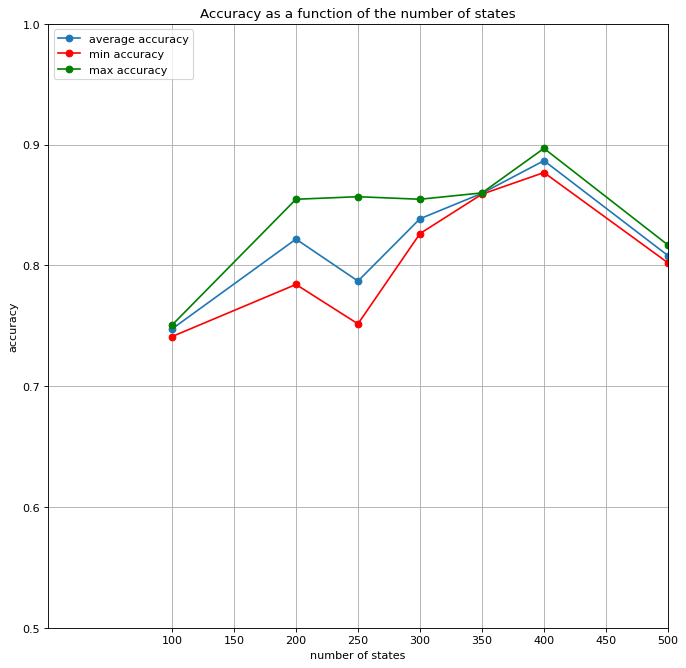

In [ ]:
with open(MODELS_DIR + "/numeral/number-of-states-accuracy-ver2.rnn2.model.pkl", 'rb') as f:
  experiment_params = pickle.load(f)

results = experiment_params['results']
results.reverse()

min_accuracy = [min(accuracy) for (n_states, accuracy) in results]
max_accuracy = [max(accuracy) for (n_states, accuracy) in results]
avg_accuracy = [sum(accuracy) / len(accuracy) for (n_states, accuracy) in results]
x = [n_states for (n_states, accuracy) in results]

figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
min_y, max_y = 0.5, 1.0
plt.ylim(min_y, max_y)
#plt.yticks(numpy.arange(min_y, max_y, 0.05))
plt.xlim(0, 500)
plt.xticks(numpy.arange(min(x), max(x) + 1, 50))
plt.grid()

plt.plot(x, avg_accuracy, '-o', label="average accuracy")
plt.plot(x, min_accuracy, '-ro', label="min accuracy")
plt.plot(x, max_accuracy, '-go', label="max accuracy")

plt.legend(loc="upper left")
plt.xlabel('number of states')
plt.ylabel('accuracy')
plt.title('Accuracy as a function of the number of states')
plt.savefig(MODELS_DIR + "/numeral/number-of-states-accuracy-ver2.rnn2.model.png")
plt.show()

Silhouette scores

In [ ]:
for n_clusters in list(range(2, 4)):

  km = KMeans(
      n_clusters=n_clusters,
      init="k-means++",
      n_init=1,
      tol=1e-7,
      random_state=0,
      precompute_distances=False,
      verbose=0,
      algorithm="full"
  )
  labels = km.fit_predict(vectors)
  centroids = km.cluster_centers_

  number_of_points_in_cluster = [0] * n_clusters
  for label in labels:
    number_of_points_in_cluster[label] += 1

  from scipy.spatial import distance

  a = [0] * vectors.shape[0]

  for i, vector_i in enumerate(vectors):
    centroid = labels[i]
    if number_of_points_in_cluster[centroid] > 1:
      sum_distances = 0
      for j, vector_j in enumerate(vectors):
        if i != j and labels[j] == centroid:
          sum_distances += distance.euclidean(vector_i, vector_j)

      a[i] = sum_distances / (number_of_points_in_cluster[centroid] - 1)

  b = [0] * vectors.shape[0]

  for i, vector_i in enumerate(vectors):
    b_i = [0] * n_clusters
    centroid = labels[i]
    for j, vector_j in enumerate(vectors):
      if labels[j] != centroid:
        b_i[labels[j]] += distance.euclidean(vector_i, vector_j)
    b_i = [bi / number_of_points_in_cluster[j] for j, bi in enumerate(b_i)]
    b_i.pop(centroid)
    b[i] = min(b_i)

  s = [0] * vectors.shape[0]
  for i in range(0, vectors.shape[0]):
    if number_of_points_in_cluster[labels[i]] > 1:
      s[i] = (b[i] - a[i]) / max(a[i], b[i])

  print(s)
  print (n_clusters, sum(s) / len(s))

In [ ]:
class Automaton():

  def __init__(self, initial_state, transitions, is_final):
    self.initial_state = initial_state
    self.is_final = is_final

    self.number_of_transitions = len(transitions)
    self.number_of_states = len(is_final)

    self.state_first_transition = [-1] * self.number_of_states
    self.state_number_of_transitions = [0] * self.number_of_states
    self.transitions_from = [-1] * self.number_of_transitions
    self.transitions_to = [-1] * self.number_of_transitions
    self.transitions_label = [-1] * self.number_of_transitions

    def compare(transition1, transition2):
      q_11, a1, q_21 = transition1
      q_12, a2, q_22 = transition2
      eq_ = q_11 - q_12
      if eq_ == 0:
        return ord(a1) - ord(a2)
      return eq_

    import functools
    sorted_transtions = sorted(transitions, key=functools.cmp_to_key(compare))

    state_index = -1
    transition_index = 0

    for transition in sorted_transtions:
      q_1, a, q_2 = transition

      if q_1 != state_index:
        self.state_first_transition[q_1] = transition_index
        state_index = q_1
      self.transitions_from[transition_index] = q_1
      self.transitions_to[transition_index] = q_2
      self.transitions_label[transition_index] = a
      transition_index += 1
      self.state_number_of_transitions[q_1] += 1

  def __print__(self):
    print("===============")
    print("number_of_states", self.number_of_states)
    print("number_of_transitions", self.number_of_transitions)
    print("initial_state", self.initial_state)
    print("is_final", list(enumerate(self.is_final)))
    print("state_first_transition", list(enumerate(self.state_first_transition)))
    print("state_number_of_transitions", list(enumerate(self.state_number_of_transitions)))
    print("transitions_from", list(enumerate(self.transitions_from)))
    print("transitions_label", list(enumerate(self.transitions_label)))
    print("transitions_to", list(enumerate(self.transitions_to)))
    print("===============")

  def is_deterministic(self):
    # dummy implementation
    for transition_index in range(self.number_of_transitions):
      transition_from = self.transitions_from[transition_index]
      transition_label = self.transitions_label[transition_index]

      for transition_index2 in range(self.number_of_transitions):
        if transition_index != transition_index2:
          transition_from2 = self.transitions_from[transition_index2]
          transition_label2 = self.transitions_label[transition_index2]
          if transition_from == transition_from2 and transition_label == transition_label2:
            print ("not deterministic ", transition_index, transition_index2, transition_from2, transition_label2, self.transitions_to[transition_index], self.transitions_to[transition_index2] )
            return False

    return True

  def contains_cycle(self):
    def dfs(stack, visited):
      while len(stack) > 0:
        top = stack.pop()
        visited[top] = True

        for i in range(self.state_number_of_transitions[top]):
          adjacent = self.transitions_to[self.state_first_transition[top] + i]
          if not visited[adjacent]:
            stack.append(adjacent)
          else:
            return True
      return False

    visited = [False] * self.number_of_states
    stack = []
    stack.append(self.initial_state)

    return dfs(stack, visited)

  def reachable_states(self):
    def dfs(stack, visited):
      while len(stack) > 0:
        top = stack.pop()
        visited[top] = True

        for i in range(self.state_number_of_transitions[top]):
          adjacent = self.transitions_to[self.state_first_transition[top] + i]
          if not visited[adjacent]:
            stack.append(adjacent)

    visited = [False] * self.number_of_states
    stack = []
    stack.append(self.initial_state)

    dfs(stack, visited)

    reachable_states = set()
    for state in range(self.number_of_states):
      if visited[state]:
        reachable_states.add(state)

    return reachable_states

  def coreachable_states(self):

    def is_coreachable(state):
      visited = [False] * self.number_of_states
      stack = []

      stack.append(state)

      while len(stack) > 0:
        top = stack.pop()
        visited[top] = True

        if self.is_final[top] == 1:
            return True

        for i in range(self.state_number_of_transitions[top]):
          adjacent = self.transitions_to[self.state_first_transition[top] + i]
          if not visited[adjacent]:
            stack.append(adjacent)

      return False

    coreachable_states = set()
    for state in range(self.number_of_states):
      if is_coreachable(state):
        coreachable_states.add(state)

    return coreachable_states

  def trim(self):

    def delete_state(state):

      first_transition = self.state_first_transition[state]
      number_of_transitions = self.state_number_of_transitions[state]
      last_transition = first_transition + number_of_transitions

      # delete out-going transitions
      self.transitions_from[first_transition:last_transition] = [-1] * number_of_transitions
      self.transitions_to[first_transition:last_transition] = [-1] * number_of_transitions
      self.transitions_label[first_transition:last_transition] = [-1] * number_of_transitions

      # delete in-comming transitions
      for transitions_index in range(self.number_of_transitions):
        if self.transitions_to[transitions_index] == state:
          transition_from = self.transitions_from[transitions_index]
          self.state_number_of_transitions[transition_from] -= 1
          self.transitions_label[transitions_index] = -1
          self.transitions_from[transitions_index] = -1
          self.transitions_to[transitions_index] = -1

      self.is_final[state] = -1
      self.state_first_transition[state] = -1
      self.state_number_of_transitions[state] = -1

    states_to_delete = set()
    reachable_and_coreachable_states = self.reachable_states() & self.coreachable_states()
    for state in range(self.number_of_states):
      if not (state in reachable_and_coreachable_states):
        states_to_delete.add(state)

    for state in states_to_delete:
      delete_state(state)

    self.number_of_states = len([state for state in self.is_final if state != -1])
    self.number_of_transitions = len([tr for tr in self.transitions_from if tr != -1])

    state_index = 0
    new_old_state, old_new_state = dict(), dict()
    for state in range(len(self.is_final)):
      if self.is_final[state] != -1:
        new_old_state[state_index] = state
        old_new_state[state] = state_index
        state_index += 1

    is_final = [-1] * self.number_of_states
    for state in new_old_state.keys():
      is_final[state] = self.is_final[new_old_state[state]]
    self.is_final = is_final

    transition_index = 0
    new_old_transition, old_new_transition = dict(), dict()
    for transition in range(len(self.transitions_from)):
      if self.transitions_from[transition] != -1:
        new_old_transition[transition_index] = transition
        old_new_transition[transition] = transition_index
        transition_index += 1

    state_number_of_transitions = [-1] * self.number_of_states
    for state in new_old_state.keys():
      state_number_of_transitions[state] = self.state_number_of_transitions[new_old_state[state]]
    self.state_number_of_transitions = state_number_of_transitions

    state_first_transition = [-1] * self.number_of_states
    for state in new_old_state.keys():
      if self.state_number_of_transitions[state] > 0:
        transition_index = self.state_first_transition[new_old_state[state]]
        while self.transitions_from[transition_index] == -1:
          transition_index += 1
        state_first_transition[state] = old_new_transition[transition_index]
    self.state_first_transition = state_first_transition

    transitions_from = [-1] * self.number_of_transitions
    transitions_to = [-1] * self.number_of_transitions
    transitions_label = [-1] * self.number_of_transitions
    for transition in new_old_transition.keys():
      transitions_from[transition] = old_new_state[self.transitions_from[new_old_transition[transition]]]
      transitions_to[transition] = old_new_state[self.transitions_to[new_old_transition[transition]]]
      transitions_label[transition] = self.transitions_label[new_old_transition[transition]]
    self.transitions_from = transitions_from
    self.transitions_to = transitions_to
    self.transitions_label = transitions_label

    self.initial_state = old_new_state[self.initial_state]

    return 

  def accepts(self, word):
    state = self.initial_state

    for character in word:
      state = self.delta(state, character)

      if state == -1:
        return False

    return (self.is_final[state] == 1)

  def delta(self, state, character):

    def binary_search(array, element, left, right):

      import bisect

      index = bisect.bisect_left(array, element, left, right)
      if index != len(array) and array[index] == element: 
          return index
      return -1


    if self.state_first_transition[state] == -1:
      return -1

    index = binary_search(
      self.transitions_label, character,
      self.state_first_transition[state],
      self.state_first_transition[state] + self.state_number_of_transitions[state]
    )
    if index == -1:
      return -1
    else:
      return self.transitions_to[index]

  def minimize(self):

    def fnv_1a(state, state_class):
      OFFSET_BASIS = 0x811C9DC5
      PRIME = 0x1000193
      MAX = 2 ** 32

      hash_code = OFFSET_BASIS
      hash_code ^= self.is_final[state]
      hash_code = (hash_code * PRIME) % MAX

      first_transition = self.state_first_transition[state]

      if first_transition != -1:

        number_of_transitions = self.state_number_of_transitions[state]
        last_transition = first_transition + number_of_transitions

        for transition_index in range(first_transition, last_transition):
          hash_code ^= ord(self.transitions_label[transition_index])
          hash_code = (hash_code * PRIME) % MAX
          hash_code ^= state_class[self.transitions_to[transition_index]]
          hash_code = (hash_code * PRIME) % MAX

      return hash_code

    def split_classes(states, state_class):
      split = False
      new_states = []
      new_state_class = dict()
      number_of_classes = 0

      for state in states:

        if len(state) == 1:
          new_states.append(state)
          (st, ) = state
          new_state_class[st] = number_of_classes
          number_of_classes += 1

        else:
          split_state = []

          hash_code_states = dict()
          for st in state:
            hash_code_ = fnv_1a(st, state_class)
            hash_code_states[hash_code_] = hash_code_states.get(hash_code_, set())
            hash_code_states[hash_code_].add(st)

          for hash_code, state in hash_code_states.items():
            # todo check for colisions
            split_state.append(state)
            for st in state:
              new_state_class[st] = number_of_classes
            number_of_classes += 1

          new_states.extend(split_state)

          if len(split_state) > 1:
              split = True

      return split, new_states, new_state_class

    state_class = dict()
    final, not_final = set(), set()
    for state in range(len(self.is_final)):
      if self.is_final[state] == 1:
        final.add(state)
        state_class[state] = 1
      else:
        not_final.add(state)
        state_class[state] = 0

    split, states, state_class = split_classes([final, not_final], state_class)

    while split:
      split, states, state_class = split_classes(states, state_class)

    #print ("at end ", states, len(states))

    number_of_states = len(states)
    initial_state = state_class[self.initial_state]
    is_final = [-1] * number_of_states
    for state in states:
      st = next(iter(state))
      is_final[state_class[st]] = self.is_final[st]

    transitions = set()
    for state in states:
      st = next(iter(state))

      first_transition = self.state_first_transition[st]

      if first_transition != -1:

        number_of_transitions = self.state_number_of_transitions[st]
        last_transition = first_transition + number_of_transitions

        for transition_index in range(first_transition, last_transition):
          transitions.add((
            state_class[st],
            self.transitions_label[transition_index],
            state_class[self.transitions_to[transition_index]]
          ))

    # print (number_of_states)
    # print (len(transitions))
    return Automaton(initial_state, transitions, is_final)

  def draw(self, file):

    from graphviz import Digraph

    nodes = set()
    for q_1 in self.transitions_from:
      nodes.add(q_1)
    for q_2 in self.transitions_to:
      nodes.add(q_2)

    filename = DATA_DIR + "/" + file
    fileformat = 'pdf'
    g = Digraph('G', filename=filename, format=fileformat)
    g.attr(rankdir='LR', size='8,5')

    for node in nodes:

      if self.is_final[node] == 1:
        if node == self.initial_state:
          g.attr('node', shape='doublecircle', style='filled', color='grey80')
        else:
          g.attr('node', shape='doublecircle', style='filled', color='grey80')
        g.node(str(node))
      else:
        if node == self.initial_state:
          g.attr('node', shape='doubleoctagon', style='filled', color='grey80')
        else:
          g.attr('node', shape='circle', style='filled', color='grey80')
        g.node(str(node))

      g.attr('node', shape='point', color="black")

    g.edge('', str(self.initial_state), label='', color="black")

    for i in range(self.number_of_transitions):
      q_1 = self.transitions_from[i]
      a = self.transitions_label[i]
      q_2 = self.transitions_to[i]

      g.edge(str(q_1), str(q_2), label=str(a))

    g.render() 

In [ ]:
def test_trim():

  initial_state = 2
  transitions = set()
  transitions.add((2, 'x', 1))
  transitions.add((0, 'x', 1))
  is_final = [0, 1, 0]
  automaton = Automaton(initial_state, transitions, is_final)

  assert automaton.contains_cycle() == False
  assert automaton.number_of_transitions == 2
  assert automaton.number_of_states == 3
  reachable_states = automaton.reachable_states()
  assert len(reachable_states) == 2
  assert reachable_states == {1, 2}
  coreachable_states = automaton.coreachable_states()
  assert len(coreachable_states) == 3
  assert coreachable_states == {0, 1, 2}
  assert automaton.accepts('x')
  automaton.trim()
  assert automaton.contains_cycle() == False
  assert automaton.number_of_transitions == 1
  assert automaton.number_of_states == 2
  assert len(automaton.reachable_states()) == 2
  assert len(automaton.coreachable_states()) == 2
  assert automaton.accepts('x')


  initial_state = 2
  transitions = set()
  transitions.add((2, 'x', 1))
  transitions.add((1, 'b', 3))
  transitions.add((1, 'c', 5))
  transitions.add((0, 'x', 1))
  transitions.add((0, 'x', 4))
  transitions.add((2, 'a', 4))
  is_final = [0, 1, 0, 0, 0, 1]
  automaton = Automaton(initial_state, transitions, is_final)

  assert automaton.contains_cycle() == False
  assert automaton.number_of_transitions == 6
  assert automaton.number_of_states == 6
  reachable_states = automaton.reachable_states()
  assert len(reachable_states) == 5
  assert reachable_states == {1, 2, 3, 4, 5}
  coreachable_states = automaton.coreachable_states()
  assert len(coreachable_states) == 4
  assert coreachable_states == {0, 1, 2, 5}
  assert automaton.accepts('x')
  assert automaton.accepts('xc')
  automaton.trim()
  assert automaton.contains_cycle() == False
  assert automaton.number_of_transitions == 2
  assert automaton.number_of_states == 3
  assert len(automaton.reachable_states()) == 3
  assert len(automaton.coreachable_states()) == 3
  assert automaton.accepts('x')
  assert automaton.accepts('xc')


  initial_state = 2
  transitions = set()
  transitions.add((2, 'a', 1))
  transitions.add((1, 'b', 0))
  is_final = [1, 1, 0]
  automaton = Automaton(initial_state, transitions, is_final)

  assert automaton.contains_cycle() == False
  assert automaton.number_of_transitions == 2
  assert automaton.number_of_states == 3
  reachable_states = automaton.reachable_states()
  assert len(reachable_states) == 3
  assert reachable_states == {0, 1, 2}
  coreachable_states = automaton.coreachable_states()
  assert len(coreachable_states) == 3
  assert coreachable_states == {0, 1, 2}
  assert automaton.accepts('ab')
  automaton.trim()
  assert automaton.contains_cycle() == False
  assert automaton.number_of_transitions == 2
  assert automaton.number_of_states == 3
  assert len(automaton.reachable_states()) == 3
  assert len(automaton.coreachable_states()) == 3
  assert automaton.accepts('ab')


  initial_state = 3
  transitions = set()
  transitions.add((0, 'a', 4))
  transitions.add((3, 'a', 4))
  transitions.add((3, 'b', 2))
  transitions.add((2, 'c', 1))
  is_final = [0, 1, 1, 0, 0]
  automaton = Automaton(initial_state, transitions, is_final)

  assert automaton.contains_cycle() == False
  assert automaton.number_of_transitions == 4
  assert automaton.number_of_states == 5
  reachable_states = automaton.reachable_states()
  assert len(reachable_states) == 4
  assert reachable_states == {1, 2, 3, 4}
  coreachable_states = automaton.coreachable_states()
  assert len(coreachable_states) == 3
  assert coreachable_states == {1, 2, 3}
  assert automaton.accepts('b')
  assert automaton.accepts('bc')
  automaton.trim()
  assert automaton.contains_cycle() == False
  assert automaton.number_of_transitions == 2
  assert automaton.number_of_states == 3
  assert len(automaton.reachable_states()) == 3
  assert len(automaton.coreachable_states()) == 3
  assert automaton.accepts('b')
  assert automaton.accepts('bc')


  initial_state = 2
  transitions = set()
  transitions.add((2, 'a', 1))
  transitions.add((1, 'b', 0))
  is_final = [0, 1, 0]
  automaton = Automaton(initial_state, transitions, is_final)

  assert automaton.contains_cycle() == False
  assert automaton.number_of_transitions == 2
  assert automaton.number_of_states == 3
  reachable_states = automaton.reachable_states()
  assert len(reachable_states) == 3
  assert reachable_states == {0, 1, 2}
  coreachable_states = automaton.coreachable_states()
  assert len(coreachable_states) == 2
  assert coreachable_states == {1, 2}
  assert automaton.accepts('a')
  automaton.trim()
  assert automaton.contains_cycle() == False
  assert automaton.number_of_transitions == 1
  assert automaton.number_of_states == 2
  assert len(automaton.reachable_states()) == 2
  assert len(automaton.coreachable_states()) == 2
  assert automaton.accepts('a')


  for iterations in range(1024):

    labels = random.sample(string.ascii_lowercase, 6)
    initial_state = 0
    transitions = set()
    transitions.add((0, labels[0], 1))
    transitions.add((0, labels[1], 2))
    transitions.add((0, labels[2], 3))
    transitions.add((0, labels[3], 4))
    transitions.add((0, labels[4], 5))
    transitions.add((0, labels[5], 6))
    is_final = [0, 1, 1, 1, 0, 0, 1]
    automaton = Automaton(initial_state, transitions, is_final)

    assert automaton.contains_cycle() == False
    assert automaton.number_of_transitions == 6
    assert automaton.number_of_states == 7
    reachable_states = automaton.reachable_states()
    assert len(reachable_states) == 7
    assert reachable_states == {0, 1, 2, 3, 4, 5, 6}
    coreachable_states = automaton.coreachable_states()
    assert len(coreachable_states) == 5
    assert coreachable_states == {0, 1, 2, 3, 6}
    assert automaton.accepts(labels[0])
    assert automaton.accepts(labels[1])
    assert automaton.accepts(labels[2])
    assert automaton.accepts(labels[5])

    automaton.trim()

    assert automaton.contains_cycle() == False
    assert automaton.number_of_transitions == 4
    assert automaton.number_of_states == 5
    assert len(automaton.reachable_states()) == 5
    assert len(automaton.coreachable_states()) == 5
    assert automaton.accepts(labels[0])
    assert automaton.accepts(labels[1])
    assert automaton.accepts(labels[2])
    assert automaton.accepts(labels[5])

test_trim()


In [ ]:
def test_minimize1():

  initial_state = 0
  transitions = set()
  transitions.add((0, 'a', 1))
  transitions.add((0, 'd', 3))
  transitions.add((1, 'b', 2))
  transitions.add((3, 'b', 2))
  is_final = [0, 1, 1, 1]
  automaton = Automaton(initial_state, transitions, is_final)

  automaton.minimize()
  print (automaton.number_of_states)

def test_minimize2():

  initial_state = 0
  transitions = set()
  transitions.add((0, 'a', 1))
  transitions.add((0, 'd', 4))
  transitions.add((1, 'b', 2))
  transitions.add((2, 'c', 3))
  transitions.add((4, 'b', 5))
  transitions.add((5, 'c', 6))
  is_final = [0, 1, 0, 1, 1, 0, 1]
  automaton = Automaton(initial_state, transitions, is_final)

  automaton = automaton.minimize()
  print (automaton.number_of_states)
  automaton.draw("min")

test_minimize2()

In [ ]:
def evaluate_model__(dataset, model, set_name):
  data_loader = utils.data.DataLoader(
    NLDataset(dataset), batch_size=1, shuffle = False
  )
  tp, tn, fp, fn = 0, 0, 0, 0

  for index, data in enumerate(data_loader):
    label = data['y'][0].item()
    result = model(data['x'], data['length'])
    prediction = result.argmax(dim=1).cpu().numpy()[0]

    x, length = data['x'], data['length']
    x = x[0].tolist()
    length = length.item()
    x = x[:length]
    x = [inv_alphabet[c] for c in x]

    if label == 1:
      if prediction == 1:
        tp += 1
        print ("M tp ", "".join(x), index)
      else:
        fn += 1
        print ("M fn ", "".join(x), index)
    else:
      if prediction == 1:
        fp += 1
        print ("M fp ", "".join(x), index)
      else:
        tn += 1
        print ("M tn ", "".join(x), index)

  if tp == 0:
    if fn == 0 and fp == 0:
      pr, r, f1 = 1, 1, 1
    else:
      pr, r, f1 = 0, 0, 0
  else:
    pr = tp / (tp + fp)
    r = tp / (tp + fn)
    f1 = 2 * ((pr * r) / (pr + r))

  accuracy = (tp + tn) / (tp + tn + fp + fn)

  print("{} : TP : {} TN : {} FP : {} FN : {} Pr : {} R : {} F1: {} ACC : {} ".format(
    set_name, tp, tn, fp, fn, pr, r, f1, accuracy
  ))

alphabet = {}
with open(DATA_DIR + "/words/alphabet.dict", "rb") as f:
  alphabet = pickle.load(f)

inv_alphabet = { v : k for k, v in alphabet.items() }

train_data = load_data(
  DATA_DIR + "/words/train.data.npy",
  DATA_DIR + "/words/train.length.npy",
  DATA_DIR + "/words/train.labels.npy"
)
dev_data = load_data(
  DATA_DIR + "/words/dev.data.npy",
  DATA_DIR + "/words/dev.length.npy",
  DATA_DIR + "/words/dev.labels.npy"
)
test_data = load_data(
  DATA_DIR + "/words/test.data.npy",
  DATA_DIR + "/words/test.length.npy",
  DATA_DIR + "/words/test.labels.npy"
)

model, params = load_model(
    params_path="/words/rnn.model.params",
    model_path="/words/rnn.model.pt"
)
print (params)
model_summary(model)

train_loader = utils.data.DataLoader(
  NLDataset(train_data), batch_size=params["batch_size"], shuffle = True
)
dev_loader = utils.data.DataLoader(
  NLDataset(dev_data), batch_size=params["batch_size"]
)
test_loader = utils.data.DataLoader(
  NLDataset(test_data), batch_size=params["batch_size"]
)


evaluate_model(train_loader, model, "train")
evaluate_model(dev_loader, model, "dev")
evaluate_model(test_loader, model, "test")

# initial_state = 0
# transitions = []

# train_loader = utils.data.DataLoader(
#   NLDataset(train_data), batch_size=1
# )

# for index, data in enumerate(train_loader):
#     x, length = data['x'], data['length']
#     softmax_output, rnn_output, transition_probabilities = model(x, length, return_probabilities=True, return_rnn_output=True)
#     prediction = softmax_output.argmax(dim=1).cpu().numpy()[0]
#     if prediction == 1:
#       transition_probabilities, _ = nn.utils.rnn.pad_packed_sequence(transition_probabilities, batch_first=True)
#       rnn_output, _ = nn.utils.rnn.pad_packed_sequence(rnn_output, batch_first=True)
#       first = x[0]
#       prev_state = initial_state
#       for t in range(length[0]):
#         l = inv_alphabet[first[t].item()]
#         next_state = torch.argmax(transition_probabilities[0, t, ]).item() + 1
#         transitions.append((prev_state, l, next_state))
#         prev_state = next_state

# start_state = torch.zeros((1, params['hidden_size']), device=device)
# #print (model.softmax(model.linear(torch.cat((start_state, model.rnn.states)))))
# is_final = model.softmax(model.linear(torch.cat((start_state, model.rnn.states)))).argmax(dim=1).cpu().tolist()

# state_symbol_to_states = defaultdict(list)

# for transition in transitions:
#   q1, a, q2 = transition
#   state_symbol_to_states[(q1, a)].append(q2)

# count_non_deterministic, count_arbitrarily = 0, 0

# transitions = set()
# for state_symbol in state_symbol_to_states:
#   states = state_symbol_to_states[state_symbol]
#   q1, a = state_symbol
#   states_set = set(states)

#   if len(states_set) == 1:
#     transitions.add((q1, a, states[0]))
#   else:
#     count_non_deterministic += 1
#     counts = Counter(states)
#     print ("WARNING: Non deterministic transitions ", q1, a, counts)
#     first_two_most_common = counts.most_common(2)

#     if len(first_two_most_common) > 1:
#       first_most_common, second_most_common = first_two_most_common
#       first_most_common_state, first_most_common_count = first_most_common
#       second_most_common_state, second_most_common_count = second_most_common
#       if first_most_common_count == second_most_common_count:
#         # should we determinize the automaton?
#         count_arbitrarily += 1
#         print ("WARNING: Selected transition is arbitrarily", q1, a, first_most_common_state)
#       transitions.add((q1, a, first_most_common_state))

#     else:
#       first_most_common = first_two_most_common[0]
#       first_most_common_state, first_most_common_count = first_most_common
#       transitions.add((q1, a, first_most_common_state))

# print ("Number of not deterministic transitions", count_non_deterministic)
# print ("Number of arbitrarily selected transitions", count_arbitrarily)

# automaton = Automaton(initial_state, transitions, is_final)
# print ("Number of states", automaton.number_of_states)
# print ("Number of transitions", automaton.number_of_transitions)
# print ("Reachable states ", len(automaton.reachable_states()))
# print ("Co-Reachable states ", len(automaton.coreachable_states()))
# #print ("DFA? ", automaton.is_deterministic())
# automaton.trim()
# print ("Number of states", automaton.number_of_states)
# print ("Number of transitions", automaton.number_of_transitions)

# automaton = automaton.minimize()
# print ("Number of states", automaton.number_of_states)
# print ("Number of transitions", automaton.number_of_transitions)
# print ("Has cycle?", automaton.contains_cycle())
# #automaton.draw("numeral-50.2.aut.min")

# def __evaluate_automaton(automaton, dataset):
#   data_loader = utils.data.DataLoader(
#     NLDataset(dataset), batch_size=1, shuffle = False
#   )
#   tp, tn, fp, fn = 0, 0, 0, 0

#   for data in data_loader:
#     label = data['y'][0].item()

#     x, length = data['x'], data['length']
#     x = x[0].tolist()
#     length = length.item()
#     x = x[:length]
#     x = [inv_alphabet[c] for c in x]

#     if automaton.accepts(x):
#       prediction = 1
#     else:
#      prediction = 0

#     if label == 1:
#       if prediction == 1:
#         tp += 1
#         print ("A tp ", "".join(x))
#       else:
#         fn += 1
#         print ("A fn ", "".join(x))
#     else:
#       if prediction == 1:
#         fp += 1
#         print ("A fp ", "".join(x))
#       else:
#         tn += 1
#         print ("A tn ", "".join(x))

#   if tp == 0:
#     if fn == 0 and fp == 0:
#       pr, r, f1 = 1, 1, 1
#     else:
#       pr, r, f1 = 0, 0, 0
#   else:
#     pr = tp / (tp + fp)
#     r = tp / (tp + fn)
#     f1 = 2 * ((pr * r) / (pr + r))

#   accuracy = (tp + tn) / (tp + tn + fp + fn)
#   return tp, tn, fp, fn, pr, r, f1, accuracy

# def _evaluate_automaton(automaton, dataset):
#   data_loader = utils.data.DataLoader(
#     NLDataset(dataset), batch_size=1, shuffle = False
#   )

#   labels, predictions = [], []

#   for data in data_loader:
#     labels.append(data['y'][0].item())

#     x, length = data['x'], data['length']
#     x = x[0].tolist()
#     length = length.item()
#     x = x[:length]
#     x = [inv_alphabet[c] for c in x]

#     if automaton.accepts(x):
#       predictions.append(1)
#     else:
#       predictions.append(0)


#   return __evaluate(predictions, labels)

# def evaluate_automaton(automaton, dataset, set_name):
#   tp, tn, fp, fn, pr, r, f1, acc = _evaluate_automaton(automaton, dataset)
#   print("{} : TP : {} TN : {} FP : {} FN : {} Pr : {} R : {} F1: {} ACC : {} ".format(
#     set_name, tp, tn, fp, fn, pr, r, f1, acc
#   ))

# evaluate_automaton(automaton, train_data, "train")
# evaluate_automaton(automaton, dev_data, "dev")
# evaluate_automaton(automaton, test_data, "test")



Automata build Second Variant

In [ ]:
def evaluate_model__(dataset, model, set_name):
  data_loader = utils.data.DataLoader(
    NLDataset(dataset), batch_size=1, shuffle = False
  )
  tp, tn, fp, fn = 0, 0, 0, 0

  for index, data in enumerate(data_loader):
    label = data['y'][0].item()
    result = model(data['x'], data['length'])
    prediction = result.argmax(dim=1).cpu().numpy()[0]

    x, length = data['x'], data['length']
    x = x[0].tolist()
    length = length.item()
    x = x[:length]
    x = [inv_alphabet[c] for c in x]

    if label == 1:
      if prediction == 1:
        tp += 1
        print ("M tp ", "".join(x), index)
      else:
        fn += 1
        print ("M fn ", "".join(x), index)
    else:
      if prediction == 1:
        fp += 1
        print ("M fp ", "".join(x), index)
      else:
        tn += 1
        print ("M tn ", "".join(x), index)

  if tp == 0:
    if fn == 0 and fp == 0:
      pr, r, f1 = 1, 1, 1
    else:
      pr, r, f1 = 0, 0, 0
  else:
    pr = tp / (tp + fp)
    r = tp / (tp + fn)
    f1 = 2 * ((pr * r) / (pr + r))

  accuracy = (tp + tn) / (tp + tn + fp + fn)

  print("{} : TP : {} TN : {} FP : {} FN : {} Pr : {} R : {} F1: {} ACC : {} ".format(
    set_name, tp, tn, fp, fn, pr, r, f1, accuracy
  ))


alphabet = {}
with open(DATA_DIR + "/numeral/alphabet.dict", "rb") as f:
  alphabet = pickle.load(f)

inv_alphabet = { v : k for k, v in alphabet.items() }

train_data = load_data(
  DATA_DIR + "/numeral/train.data.npy",
  DATA_DIR + "/numeral/train.length.npy",
  DATA_DIR + "/numeral/train.labels.npy"
)
dev_data = load_data(
  DATA_DIR + "/numeral/dev.data.npy",
  DATA_DIR + "/numeral/dev.length.npy",
  DATA_DIR + "/numeral/dev.labels.npy"
)
test_data = load_data(
  DATA_DIR + "/numeral/test.data.npy",
  DATA_DIR + "/numeral/test.length.npy",
  DATA_DIR + "/numeral/test.labels.npy"
)

model, params = load_model(
    params_path="/numeral/st-debug-rnn2.model.params",
    model_path="/numeral/st-debug-rnn2.model.pt"
)
print (params)
# model_summary(model)

train_loader = utils.data.DataLoader(
  NLDataset(train_data), batch_size=params["batch_size"], shuffle = True
)
dev_loader = utils.data.DataLoader(
  NLDataset(dev_data), batch_size=params["batch_size"]
)
test_loader = utils.data.DataLoader(
  NLDataset(test_data), batch_size=params["batch_size"]
)

# evaluate_model__(train_data, model, "train")
evaluate_model(train_loader, model, "train")
evaluate_model(dev_loader, model, "dev")
evaluate_model(test_loader, model, "test")

initial_state = 0
transitions = set()
states = set()
queue = [initial_state]

x = torch.tensor(list(inv_alphabet.keys()), device=device).unsqueeze(1)
length = torch.ones(len(inv_alphabet), device=device)

while len(queue) != 0:

  current_state = queue.pop(0)
  states.add(current_state)

  if current_state == initial_state:
    h_0 = torch.zeros((len(inv_alphabet), params['hidden_size']), device=device)
  else:
    h_0 = model.rnn.states[current_state - 1].expand(len(inv_alphabet), -1)

  softmax_output, rnn_output, transition_probabilities = model(x, length, h_0=h_0, return_probabilities=True, return_rnn_output=True)
  transition_probabilities, _ = nn.utils.rnn.pad_packed_sequence(transition_probabilities, batch_first=True)
  probabilties, next_states = torch.max(transition_probabilities[:, 0, ], dim=1)
  # if current_state == 0:
  #   print (next_states)
  #   print (probabilties)
  #   print (torch.max(transition_probabilities[:, 0, ], dim=1))

  next_states += 1

  for i, char in enumerate(inv_alphabet):
    l = inv_alphabet[char]
    # if current_state == 0:
    #   print ((current_state, l, next_states[i].item()))
    #   print(probabilties.size(), probabilties[i].item())
    transitions.add((current_state, l, next_states[i].item(), probabilties[i].item()))

  for state in set(next_states.detach().cpu().tolist()):
    if state not in states and state not in queue:
      queue.append(state)

print ("transitiooons ", len(transitions))

ps = [ps for (q1,l,q2,ps) in transitions]
print (min(ps))
print (max(ps))

threshold = 0
transitions = [(q1,l,q2) for (q1,l,q2,ps) in transitions if ps > threshold]
print ("transitiooons ", len(transitions))
# print (states)
# print (initial_state)

mapping = { state : i for i, state in enumerate(states)}
start_state = torch.zeros((1, params['hidden_size']), device=device)
is_final = model.softmax(model.linear(torch.cat((start_state, model.rnn.states)))).argmax(dim=1).cpu().tolist()

trs = set()
for tr in transitions:
  q1, l, q2 = tr
  trs.add((mapping[q1], l, mapping[q2]))

isf = []
for k, v in mapping.items():
  isf.append(is_final[k])

print ("mapping ", mapping)
print ("trrrrs ", trs)
print (isf)

automaton = Automaton(initial_state, trs, isf)
print ("Number of states", automaton.number_of_states)
print ("Number of transitions", automaton.number_of_transitions)
print ("Reachable states ", len(automaton.reachable_states()))
print ("Co-Reachable states ", len(automaton.coreachable_states()))
print ("DFA? ", automaton.is_deterministic())
automaton.trim()
print ("Number of states", automaton.number_of_states)
print ("Number of transitions", automaton.number_of_transitions)

automaton = automaton.minimize()
print ("Number of states", automaton.number_of_states)
print ("Number of transitions", automaton.number_of_transitions)
print ("Has cycle?", automaton.contains_cycle())

print ("frrro ", automaton.transitions_from)
print ("frrro ", automaton.transitions_to)
print ("frrro ", automaton.transitions_label)

def __evaluate_automaton(automaton, dataset):
  data_loader = utils.data.DataLoader(
    NLDataset(dataset), batch_size=1, shuffle = False
  )
  tp, tn, fp, fn = 0, 0, 0, 0

  for data in data_loader:
    label = data['y'][0].item()

    x, length = data['x'], data['length']
    x = x[0].tolist()
    length = length.item()
    x = x[:length]
    x = [inv_alphabet[c] for c in x]

    if automaton.accepts(x):
      prediction = 1
    else:
     prediction = 0

    if label == 1:
      if prediction == 1:
        tp += 1
        print ("A tp ", "".join(x))
      else:
        fn += 1
        print ("A fn ", "".join(x))
    else:
      if prediction == 1:
        fp += 1
        print ("A fp ", "".join(x))
      else:
        tn += 1
        print ("A tn ", "".join(x))

  if tp == 0:
    if fn == 0 and fp == 0:
      pr, r, f1 = 1, 1, 1
    else:
      pr, r, f1 = 0, 0, 0
  else:
    pr = tp / (tp + fp)
    r = tp / (tp + fn)
    f1 = 2 * ((pr * r) / (pr + r))

  accuracy = (tp + tn) / (tp + tn + fp + fn)
  return tp, tn, fp, fn, pr, r, f1, accuracy

def _evaluate_automaton(automaton, dataset):
  data_loader = utils.data.DataLoader(
    NLDataset(dataset), batch_size=1, shuffle = False
  )

  labels, predictions = [], []

  for data in data_loader:
    labels.append(data['y'][0].item())

    x, length = data['x'], data['length']
    x = x[0].tolist()
    length = length.item()
    x = x[:length]
    try:
      x = [inv_alphabet[c] for c in x]
    except:
      print (inv_alphabet)
      raise

    if automaton.accepts(x):
      predictions.append(1)
    else:
      predictions.append(0)


  return __evaluate(predictions, labels)

def evaluate_automaton(automaton, dataset, set_name):
  tp, tn, fp, fn, pr, r, f1, acc = _evaluate_automaton(automaton, dataset)
  print("{} : TP : {} TN : {} FP : {} FN : {} Pr : {} R : {} F1: {} ACC : {} ".format(
    set_name, tp, tn, fp, fn, pr, r, f1, acc
  ))
#__evaluate_automaton(automaton, train_data)
evaluate_automaton(automaton, train_data, "train")
evaluate_automaton(automaton, dev_data, "dev")
evaluate_automaton(automaton, test_data, "test")
# print(automaton.transitions_from)
# print(automaton.transitions_to)
# print(automaton.transitions_label)

# ya
# kur = torch.tensor([[13]]).to(device)
# l = torch.tensor([1]).to(device)
# res = model(kur, l)
# print ("model soft out ",res)
# print(res.argmax(dim=1).detach().cpu().numpy())
# print("state 3 ",model.rnn.states[16])

# omodel, oparams = load_model(
#     params_path="/numeral-50/rnn2.model.params",
#     model_path="/numeral-50/rnn2.model.pt"
# )
# # import sys
#numpy.set_printoptions(threshold=sys.maxsize)
#centers = numpy.load(MODELS_DIR + "/numeral-50/st-debug-rnn2.model.centers.npy")
#print(centers)
# softmax_output, rnn_output = omodel(kur, l, return_rnn_output=True)
# print ("omodel soft output ",softmax_output)
# print ("omodel rnn output ", rnn_output)
# print(softmax_output.argmax(dim=1).detach().cpu().numpy())
print (alphabet)

{'batch_size': 10, 'num_epochs': 100, 'num_embeddings': 23, 'mode': 'rnn', 'nonlinearity': 'relu', 'hidden_size': 8, 'bias': False, 'lr': 0.0001, 'weight_decay': 0.005, 'number_of_states': 500, 'temperature': 0.1}
train : TP : 457 TN : 420 FP : 51 FN : 22 Pr : 0.8996062992125984 R : 0.954070981210856 F1: 0.9260385005065855 ACC : 0.9231578947368421 
dev : TP : 52 TN : 48 FP : 17 FN : 2 Pr : 0.7536231884057971 R : 0.9629629629629629 F1: 0.8455284552845528 ACC : 0.8403361344537815 
test : TP : 56 TN : 44 FP : 14 FN : 5 Pr : 0.8 R : 0.9180327868852459 F1: 0.8549618320610688 ACC : 0.8403361344537815 
transitiooons  11454
0.1431421935558319
1.0
transitiooons  11454
mapping  {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24, 25: 25, 26: 26, 27: 27, 28: 28, 29: 29, 30: 30, 31: 31, 32: 32, 33: 33, 34: 34, 35: 35, 36: 36, 37: 37, 38: 38, 39: 39, 40: 40, 41: 41, 42: 42